In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms, models
import os
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [4]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

In [6]:
# Load a pre-trained DenseNet-121 model
model = models.densenet121(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Replace the classifier with a new one suitable for 6 classes
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 6)

In [8]:
model.to(device).eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 6960006


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
epochs = 40
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 20  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e + 1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e + 1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

            # Save the model weights when validation accuracy is at its maximum
            torch.save(model.state_dict(), 'best_DenseNet121_weights.pth')

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e + 1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0405, acc 0.5368
validation loss: 0.0360, validation acc 0.6100
time taken for epoch 1: 60.60 seconds
epoch: 2
training loss: 0.0313, acc 0.6301
validation loss: 0.0413, validation acc 0.5863
time taken for epoch 2: 54.26 seconds
epoch: 3
training loss: 0.0266, acc 0.6957
validation loss: 0.0228, validation acc 0.7497
time taken for epoch 3: 17.45 seconds
epoch: 4
training loss: 0.0231, acc 0.7393
validation loss: 0.0187, validation acc 0.7721
time taken for epoch 4: 17.68 seconds
epoch: 5
training loss: 0.0213, acc 0.7653
validation loss: 0.0224, validation acc 0.7523
time taken for epoch 5: 17.73 seconds
epoch: 6
training loss: 0.0216, acc 0.7613
validation loss: 0.0219, validation acc 0.7655
time taken for epoch 6: 17.73 seconds
epoch: 7
training loss: 0.0161, acc 0.8196
validation loss: 0.0174, validation acc 0.8208
time taken for epoch 7: 17.92 seconds
epoch: 8
training loss: 0.0163, acc 0.8173
validation loss: 0.0196, validation acc 0.7931
time taken for

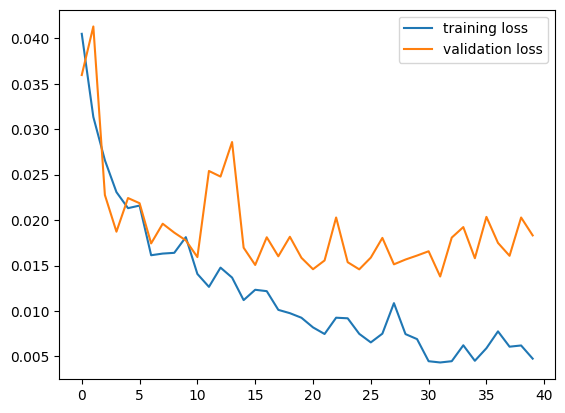

In [12]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

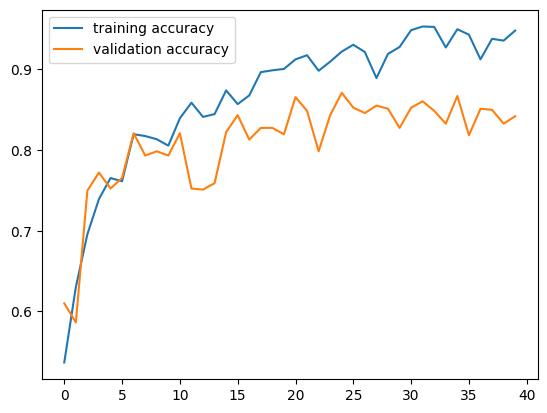

In [13]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [15]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [16]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[281   3   0   3   0   0]
 [  1 337   7   6   1   2]
 [  0   3 277   2   0   4]
 [  2   0   0 399   0   2]
 [  3  10   1  20 305   8]
 [  0   2   1   3   0  85]]

Precision for each class:
cardboard: 0.9791
glass: 0.9493
metal: 0.9685
paper: 0.9215
plastic: 0.9967
trash: 0.8416

Recall for each class:
cardboard: 0.9791
glass: 0.9520
metal: 0.9685
paper: 0.9901
plastic: 0.8790
trash: 0.9341


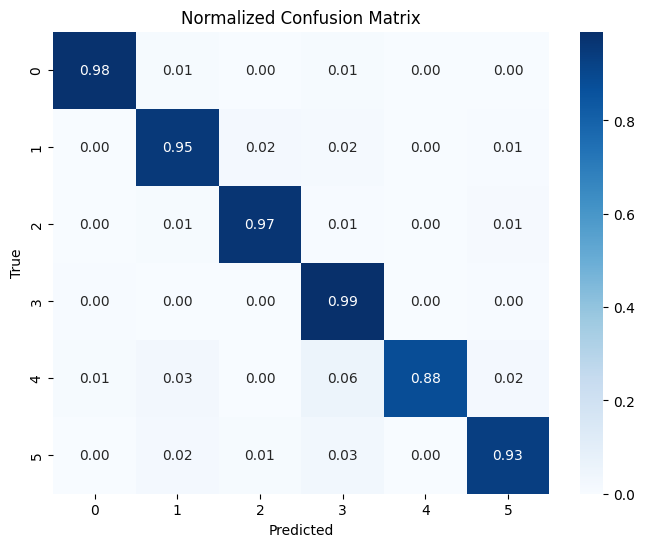

In [17]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.9547


In [19]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.9525
Overall F1 Score: 0.9524


In [20]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[107   0   1   7   1   0]
 [  2 112  22   2   8   1]
 [  4   3 106   5   4   2]
 [  4   0   0 182   0   5]
 [  4  13   5  10  93  10]
 [  1   2   1   2   1  39]]

Precision for each class:
cardboard: 0.8770
glass: 0.8615
metal: 0.7852
paper: 0.8750
plastic: 0.8692
trash: 0.6842

Recall for each class:
cardboard: 0.9224
glass: 0.7619
metal: 0.8548
paper: 0.9529
plastic: 0.6889
trash: 0.8478


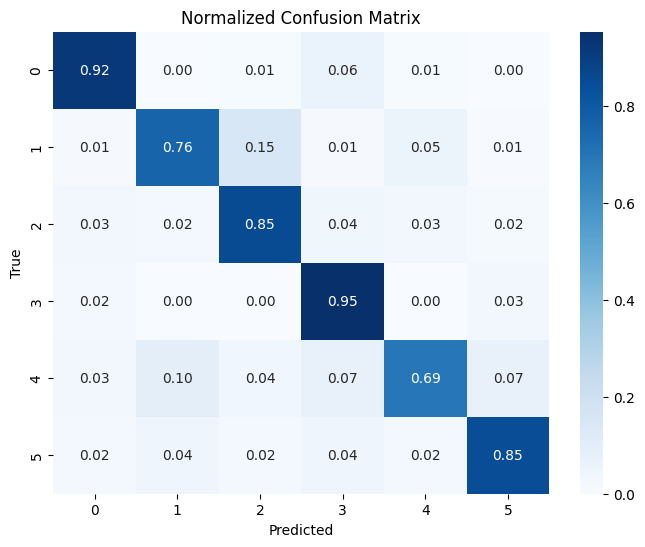

In [22]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels_t),
            yticklabels=np.unique(all_labels_t))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.8454


In [24]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.8419
Overall F1 Score: 0.8399
